In [14]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import collections
import functools
import itertools
import math
import copy
import subprocess
import datetime
from functools import partial

# visualization libraries
%matplotlib inline
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy
import skimage
import torch
import torch.nn.functional as F
import einops
import dipy
import nibabel as nib

import pitn

plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})
plt.rcParams.update({"image.interpolation": "antialiased"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def log_prefix():
    return f"{datetime.datetime.now().replace(microsecond=0)}"


def nib_fdata_loader(nib_im, dtype=np.float32, **get_fdata_kwargs):
    im = nib_im.get_fdata(**get_fdata_kwargs).astype(dtype)
    if len(im.shape) == 4:
        im = np.moveaxis(im, -1, 0)
    if "caching" in get_fdata_kwargs.keys():
        if get_fdata_kwargs["caching"] == "unchanged":
            nib_im.uncache()
    return im

In [16]:
device = torch.device("cpu")

The spherical coordinate system is defined as $\left( r, \theta, \phi \right)$:
* $r$ is radius/radial distance, $r \geq 0$
* $\theta$ is the polar angle/inclination/zenith angle/colatitude in radians, where $0 \leq \theta \leq \pi$. 
    Described as the angle with respect to the positive polar axis, typically the
    "north pole" or the cartesian coordinate $\left(x=0, y=0, z=1\right)$. This angle
    is also described as the "elevation angle", but typically the elevation angle is
    measured with respect to the $XY$ plane.
* $\phi$ is the azimuth angle in radians, where $0 \leq \phi < 2 \pi$.
    Described as the angle of rotation from the positive x-axis (at $(x=1, y=0, z=0)$)
    to the positive y-axis $(x=0, y=1, z=0)$, counterclockwise (when looking "down" from the "north pole").

<https://en.wikipedia.org/wiki/Spherical_coordinate_system>

In [45]:
def plot_odf_derivs(
    sh_coeffs,
    l_max,
    plot_finite_diffs=True,
    points_to_plot_theta_phi: tuple = None,
    epsilon_theta=1e-2,
    epsilon_phi=1e-2,
    imshow_kwargs: dict = dict(),
    contour_kwargs: dict = dict(),
    scatter_kwargs: dict = dict(),
):
    def sphere2cart_coords(r, polar, azimuth):
        theta = polar
        phi = azimuth
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        return x, y, z

    def cart2sphere_coords(x, y, z):
        r = np.linalg.norm(np.stack([x, y, z], axis=-1), ord=2, axis=-1)
        theta = np.arccos(z / r)
        # The discontinuities of atan2 mean we have to shift and cycle some values, but
        # not others. Even though atan2 is in the (-pi, pi], the actual mapping onto that
        # range does not allow a simple addition of pi to get the correct spherical coords.
        # Shift the negative values by 2*pi to bring into the range of the azimuth angle
        # back to [0, 2*pi).
        phi = np.arctan2(y, x) % (2 * np.pi)
        # phi = np.where(phi < 0, phi + 2 * np.pi, phi)
        return r, theta, phi

    def get_degree_order_vecs(l_max: int):
        unique_l = np.arange(0, l_max + 2, 2).astype(int)
        l_degrees = list()
        m_orders = list()
        for l in unique_l:
            for m in np.arange(-l, l + 1):
                l_degrees.append(l)
                m_orders.append(m)
        return np.array(l_degrees).astype(int), np.array(m_orders).astype(int)

    def spherical_harmonic(order, degree, polar, azimuth):
        theta_scipy = azimuth
        phi_scipy = polar
        return scipy.special.sph_harm(order, degree, theta_scipy, phi_scipy)

    def sh_basis_mrtrix3(
        azimuth,
        polar,
        order,
        degree,
    ):
        Y_m_abs_l = spherical_harmonic(
            order=np.abs(order), degree=degree, polar=polar, azimuth=azimuth
        )
        Y_m_abs_l = np.where(order < 0, np.sqrt(2) * Y_m_abs_l.imag, Y_m_abs_l)
        Y_m_abs_l = np.where(order > 0, np.sqrt(2) * Y_m_abs_l.real, Y_m_abs_l)
        return Y_m_abs_l.real

    def sh_normalize_coeff(l: np.ndarray, m: np.ndarray):
        # Tested against scipy's sph_harm, should be correct.
        f1 = (2 * l + 1) / (4 * np.pi)
        f2 = scipy.special.factorial(l - m) / scipy.special.factorial(l + m)
        return np.sqrt(f1 * f2)

    def sample_odf(sh_coeffs, l_max, theta, phi):
        l, m = get_degree_order_vecs(l_max)
        l = l[None]
        m = m[None]
        theta = theta[..., None]
        phi = phi[..., None]
        Y_l_m_star = sh_basis_mrtrix3(azimuth=phi, polar=theta, order=m, degree=l)
        return (sh_coeffs * Y_l_m_star).sum(-1)

    fd_thetas = np.arange(0, np.pi, step=epsilon_theta)
    fd_phis = np.arange(0, 2 * np.pi, step=epsilon_phi)

    grid_thetas, grid_phis = np.meshgrid(fd_thetas, fd_phis, indexing="ij")
    samples = sample_odf(sh_coeffs, l_max, grid_thetas, grid_phis)

    fd_ds_dtheta = (samples[2:] - samples[:-2]) / (2 * epsilon_theta)
    fd_ds_dphi = (samples[:, 2:] - samples[:, :-2]) / (2 * epsilon_phi)

    if plot_finite_diffs:
        fig, axs = plt.subplots(
            nrows=3, dpi=150, figsize=(4, 12), squeeze=True, tight_layout=True
        )
        ax = axs[0]
    else:
        fig, ax = plt.subplots(dpi=150, figsize=(4, 4), squeeze=True, tight_layout=True)
        axs = None

    extent = (fd_thetas[0], fd_thetas[-1], fd_phis[0], fd_phis[-1])
    im = ax.imshow(
        samples.T,
        cmap="gray",
        aspect="auto",
        interpolation="bilinear",
        origin="lower",
        extent=extent,
        **imshow_kwargs,
    )
    fig.colorbar(im, shrink=0.4, orientation="horizontal", ax=ax)
    # levels = np.arange(0, samples.max(), 0.25)
    contour = ax.contour(
        fd_thetas,
        fd_phis,
        samples.T,
        # levels=levels,
        origin="lower",
        cmap="magma",
        extend="both",
        **contour_kwargs,
        # extent=(fd_thetas[0], fd_thetas[-1], fd_phis[0], fd_phis[-1]),
    )
    fig.colorbar(contour, shrink=0.4, ax=ax)
    ax.set_ylabel(r"$\phi$")
    ax.set_xlabel(r"$\theta$")
    ax.set_title("ODF Samples on the Sphere")

    if plot_finite_diffs:
        ax = axs[1]
        extent = (fd_thetas[1], fd_thetas[-2], fd_phis[0], fd_phis[-1])
        im = ax.imshow(
            fd_ds_dtheta.T,
            cmap="gray",
            aspect="auto",
            interpolation="bilinear",
            origin="lower",
            extent=extent,
            **imshow_kwargs,
        )
        # levels = np.arange(0, samples.max(), 0.25)
        contour = ax.contour(
            fd_thetas[1:-1],
            fd_phis,
            fd_ds_dtheta.T,
            # levels=levels,
            origin="lower",
            cmap="coolwarm",
            extend="both",
            extent=extent,
            **contour_kwargs,
        )
        fig.colorbar(contour, shrink=0.4, ax=ax)
        fig.colorbar(im, shrink=0.4, orientation="horizontal", ax=ax)
        ax.set_ylabel(r"$\phi$")
        ax.set_xlabel(r"$\theta$")
        ax.set_title(r"Finite Difference Approx. $\frac{df}{d\theta}$")

        ax = axs[2]
        extent = (fd_thetas[0], fd_thetas[-1], fd_phis[1], fd_phis[-2])
        im = ax.imshow(
            fd_ds_dphi.T,
            cmap="gray",
            aspect="auto",
            interpolation="bilinear",
            origin="lower",
            extent=extent,
            **imshow_kwargs,
        )
        # # levels = np.arange(0, samples.max(), 0.25)
        contour = ax.contour(
            fd_thetas,
            fd_phis[1:-1],
            fd_ds_dphi.T,
            # levels=levels,
            origin="lower",
            cmap="coolwarm",
            extend="both",
            **contour_kwargs,
            # extent=extent,
        )
        fig.colorbar(im, shrink=0.4, orientation="horizontal", ax=ax)
        fig.colorbar(contour, shrink=0.4, ax=ax)
        ax.set_title(r"Finite Difference Approx. $\frac{df}{d\phi}$")

    if points_to_plot_theta_phi is not None:
        p_theta = points_to_plot_theta_phi[0].cpu().numpy()
        p_phi = points_to_plot_theta_phi[1].cpu().numpy()
        steps_cmap = mpl.cm.gist_rainbow(
            np.linspace(0, 1, num=len(p_theta), endpoint=True)
        )
        if plot_finite_diffs:
            ax = axs[0]
        ax.scatter(
            p_theta,
            p_phi,
            color=steps_cmap,
            **(dict(s=0.3, lw=1.0) | scatter_kwargs),
            zorder=1000.0,
        )

    return fig

## Data Prep

In [18]:
odf_f = Path(
    "../sandbox/peak_finding/173536_trilin-dwi-upsample_wm_msmt_csd_odf.nii.gz"
)
mask_f = Path("/data/srv/outputs/pitn/hcp/173536/ras/brain_mask.nii.gz")
gt_peaks_f = Path(
    "../sandbox/peak_finding/173536_trilin-dwi-upsample_test-seed_peaks.nii.gz"
)
seed_peaks_f = Path("../sandbox/peak_finding/test_dirs_cartesian.txt")

odf_im = nib.load(odf_f)
mask_im = nib.load(mask_f)
gt_peaks_im = nib.load(gt_peaks_f)

odf = nib_fdata_loader(odf_im, np.float32)
odf = torch.from_numpy(odf)
mask = nib_fdata_loader(mask_im, bool)
mask = torch.from_numpy(mask)[None]
# Calculated using mrtrix, as described in code here:
# <https://github.com/MRtrix3/mrtrix3/blob/e757e07081a619bbdd36e58648dc8dbfade56467/core/math/SH.h#L508>
gt_peaks = nib_fdata_loader(gt_peaks_im, np.float32)
n_peaks = gt_peaks.shape[0] // 3
gt_peaks = einops.rearrange(
    torch.from_numpy(gt_peaks),
    "(n_peaks coord) x y z -> n_peaks x y z coord",
    n_peaks=n_peaks,
)
print(odf.shape, mask.shape, gt_peaks.shape)

seed_cart_peaks = np.loadtxt(seed_peaks_f, comments="#")
seed_cart_peaks = pd.DataFrame(seed_cart_peaks, columns=("x", "y", "z"))

theta, phi = pitn.tract.xyz2unit_sphere_theta_phi(
    torch.from_numpy(
        np.stack(
            [
                seed_cart_peaks.x.to_numpy(),
                seed_cart_peaks.y.to_numpy(),
                seed_cart_peaks.z.to_numpy(),
            ],
            axis=-1,
        )
    )
)
seed_sphere_peaks = pd.DataFrame(
    np.stack([theta, phi], -1), columns=("polar", "azimuth")
)
# roundtrip_cart_peaks = sphere2cart_coords(seed_sphere_peaks.r.to_numpy(), seed_sphere_peaks.polar.to_numpy(), seed_sphere_peaks.azimuth.to_numpy())
# assert (np.linalg.norm(seed_cart_peaks.to_numpy() - np.stack(roundtrip_cart_peaks, -1), ord=2, axis=-1) <= 1e-6).all()
pprint(seed_sphere_peaks)
pprint(seed_cart_peaks)

torch.Size([45, 113, 146, 116]) torch.Size([1, 113, 146, 116]) torch.Size([2, 113, 146, 116, 3])
       polar   azimuth
0   2.972557  3.939456
1   2.301042  3.276755
2   0.883126  4.031047
3   1.442539  0.573830
4   1.323326  5.805485
5   2.071288  5.352360
6   2.573561  6.124621
7   2.487764  1.968842
8   0.877756  1.309787
9   1.610596  1.268360
10  1.272183  3.133505
11  1.754401  1.935938
           x         y         z
0  -0.117466 -0.120431 -0.985748
1  -0.738216 -0.100391 -0.667053
2  -0.486691 -0.600198  0.634739
3   0.832930  0.538394  0.127906
4   0.861000 -0.445733  0.244952
5   0.523927 -0.703731 -0.479857
6   0.531225 -0.084947 -0.842961
7  -0.235760  0.560679 -0.793761
8   0.198524  0.743251  0.638879
9   0.297611  0.953858 -0.039789
10 -0.955714  0.007730  0.294195
11 -0.351080  0.918373 -0.182575


In [62]:
l_max = 8
l, m = pitn.tract.peak_finding._get_degree_order_vecs(l_max, batch_size=2)

vox_idx_1 = (59, 107, 60)
seed_peak_1_idx = 3
sh_coeff_1 = odf[:, vox_idx_1[0], vox_idx_1[1], vox_idx_1[2]].numpy()
gt_peak_xyz_1 = gt_peaks[:, vox_idx_1[0], vox_idx_1[1], vox_idx_1[2]]
gt_peak_sph_1 = pitn.tract.xyz2unit_sphere_theta_phi(gt_peak_xyz_1)
seed_peak_xyz_1 = torch.from_numpy(seed_cart_peaks.iloc[seed_peak_1_idx].to_numpy())
seed_peak_sph_1 = pitn.tract.xyz2unit_sphere_theta_phi(seed_peak_xyz_1.unsqueeze(0))

vox_idx_2 = (65, 96, 80)
seed_peak_2_idx = 9
sh_coeff_2 = odf[:, vox_idx_2[0], vox_idx_2[1], vox_idx_2[2]].numpy()
gt_peak_xyz_2 = gt_peaks[:, vox_idx_2[0], vox_idx_2[1], vox_idx_2[2]]
gt_peak_sph_2 = pitn.tract.xyz2unit_sphere_theta_phi(gt_peak_xyz_2)
seed_peak_xyz_2 = torch.from_numpy(seed_cart_peaks.iloc[seed_peak_2_idx].to_numpy())
seed_peak_sph_2 = pitn.tract.xyz2unit_sphere_theta_phi(seed_peak_xyz_2.unsqueeze(0))

b_sh_coeffs = torch.from_numpy(np.stack([sh_coeff_1, sh_coeff_2], 0))
b_gt_peaks_theta = torch.from_numpy(np.stack([gt_peak_sph_1[0], gt_peak_sph_2[0]], 0))
b_gt_peaks_phi = torch.from_numpy(np.stack([gt_peak_sph_1[1], gt_peak_sph_2[1]], 0))
b_gt_peaks = torch.stack([b_gt_peaks_theta, b_gt_peaks_phi], -1)
b_seed_peaks_theta = torch.from_numpy(
    np.stack([seed_peak_sph_1[0], seed_peak_sph_2[0]], 0)
)
b_seed_peaks_phi = torch.from_numpy(
    np.stack([seed_peak_sph_1[1], seed_peak_sph_2[1]], 0)
)
b_seed_peaks = torch.stack([b_seed_peaks_theta, b_seed_peaks_phi], -1)

print(b_gt_peaks_theta)
print(b_gt_peaks_phi)
print(b_gt_peaks)
print("=" * 60)
print(b_seed_peaks_theta)
print(b_seed_peaks_phi)
print(b_seed_peaks)

tensor([[1.4780, 0.1895],
        [1.0508, 0.2273]])
tensor([[0.4347, 2.9241],
        [3.0889, 0.6130]])
tensor([[[1.4780, 0.4347],
         [0.1895, 2.9241]],

        [[1.0508, 3.0889],
         [0.2273, 0.6130]]])
tensor([[1.4425],
        [1.6106]], dtype=torch.float64)
tensor([[0.5738],
        [1.2684]], dtype=torch.float64)
tensor([[[1.4425, 0.5738]],

        [[1.6106, 1.2684]]], dtype=torch.float64)


In [20]:
# plot both odfs in the batch
fig = plot_odf_derivs(
    b_sh_coeffs[0].numpy(), l_max=8, epsilon_theta=4e-3, epsilon_phi=8e-3
)
plt.show()
fig = plot_odf_derivs(
    b_sh_coeffs[1].numpy(), l_max=8, epsilon_theta=4e-3, epsilon_phi=8e-3
)
plt.show()

KeyboardInterrupt: 

In [63]:
seed_sphere_peaks
b_seed_theta = torch.from_numpy(seed_sphere_peaks.polar.to_numpy())
b_seed_phi = torch.from_numpy(seed_sphere_peaks.azimuth.to_numpy())

fn_peak_finding = partial(
    pitn.tract.peak_finding.find_peak_grad_ascent,
    lr=0.1,
    momentum=0.5,
    max_epochs=250,
    l_max=8,
)
broad_l, broad_m = pitn.tract.peak_finding._get_degree_order_vecs(l_max, batch_size=1)
fn_basis = partial(
    pitn.tract.peak_finding._sh_basis_mrtrix3, degree=broad_l, order=broad_m
)

topk_theta, topk_phi, topk_amp = pitn.tract.seed.get_topk_starting_peaks(
    b_sh_coeffs,
    b_seed_theta,
    b_seed_phi,
    fn_peak_finding__sh_theta_phi2theta_phi=fn_peak_finding,
    fn_sh_basis=fn_basis,
    max_n_peaks=2,
    min_odf_height=0.1,
    min_peak_arc_len=15 * (torch.pi / 180),
)
valid_peak_mask = topk_amp == 0.0

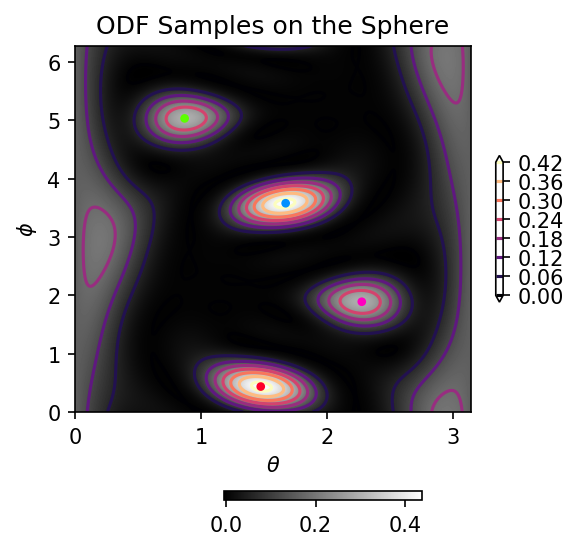

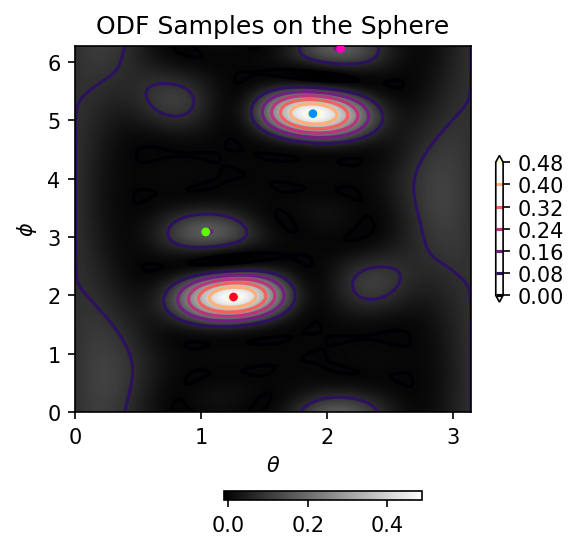

In [65]:
# plot both odfs in the batch
fig = plot_odf_derivs(
    b_sh_coeffs[0].numpy(),
    l_max=8,
    plot_finite_diffs=False,
    points_to_plot_theta_phi=(topk_theta[0].flatten(), topk_phi[0].flatten()),
    epsilon_theta=4e-3,
    epsilon_phi=8e-3,
    scatter_kwargs=dict(s=10),
)
plt.show()
fig = plot_odf_derivs(
    b_sh_coeffs[1].numpy(),
    l_max=8,
    plot_finite_diffs=False,
    points_to_plot_theta_phi=(topk_theta[1].flatten(), topk_phi[1].flatten()),
    epsilon_theta=4e-3,
    epsilon_phi=8e-3,
    scatter_kwargs=dict(s=10),
)
plt.show()

---

In [ ]:
# Plot results of batched gradient ascent.
grad_ascent_steps = einops.rearrange(
    param_steps, "steps b theta_phi -> b steps theta_phi"
)

batch_size = grad_ascent_steps.shape[0]

epsilon_theta = 1e-2
epsilon_phi = 1e-2
# sh_coeffs = sh_coeff
fd_thetas = np.arange(0, np.pi, step=epsilon_theta)
fd_phis = np.arange(0, 2 * np.pi, step=epsilon_phi)

grid_thetas, grid_phis = np.meshgrid(fd_thetas, fd_phis, indexing="ij")
samples = (
    sample_odf(b_sh_coeffs[0].cpu().numpy(), l_max, grid_thetas, grid_phis),
    sample_odf(b_sh_coeffs[1].cpu().numpy(), l_max, grid_thetas, grid_phis),
)

fig, axs = plt.subplots(
    ncols=batch_size, dpi=150, figsize=(8, 5), tight_layout=True, sharey=True
)

extent = (fd_thetas[0], fd_thetas[-1], fd_phis[0], fd_phis[-1])

for i in range(batch_size):
    ax = axs[i]
    im = ax.imshow(
        samples[i].T,
        cmap="gray",
        aspect="auto",
        interpolation="bilinear",
        origin="lower",
        extent=extent,
    )
    fig.colorbar(im, shrink=0.4, orientation="horizontal", ax=ax)
    # levels = np.arange(0, samples.max(), 0.25)
    contour = ax.contour(
        fd_thetas,
        fd_phis,
        samples[i].T,
        # levels=levels,
        origin="lower",
        cmap="magma",
        extend="both",
        alpha=0.6,
        # extent=(fd_thetas[0], fd_thetas[-1], fd_phis[0], fd_phis[-1]),
    )
    fig.colorbar(contour, shrink=0.4, ax=ax)
    ax.set_ylabel(r"$\phi$")
    ax.set_xlabel(r"$\theta$")

    sgd_params_progression = grad_ascent_steps[i].cpu().numpy()
    sgd_theta_progression = sgd_params_progression[:, 0]
    sgd_phi_progression = sgd_params_progression[:, 1]
    steps_cmap = mpl.cm.gist_rainbow(
        np.linspace(0, 1, num=len(sgd_theta_progression), endpoint=True)
    )
    # step_colors = np.linspace(0.05, 0.95, num=len(sgd_theta_progression), endpoint=True)
    ax.scatter(
        sgd_theta_progression, sgd_phi_progression, color=steps_cmap, s=0.3, lw=1.0
    )
    # ax.set_title("ODF Samples on the Sphere");